In [1]:
import umap
import umap.plot
from umap.parametric_umap import ParametricUMAP

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import cluster
from sklearn import metrics


import itertools
from pathlib import Path

# Functions

In [2]:
def flatten(arr, num_vals=None):
    num_vals = len(arr) if not num_vals else num_vals
    return arr.reshape(num_vals, -1)


def get_layer_output(model, idx, x):
    OutFunc = tf.keras.backend.function([model.input], [model.layers[idx].output])
    return OutFunc(np.expand_dims(x, axis=0))[0]


def each_layer_outputs(model, x):
    outputs = []
    for idx in range(0, len(model.layers)):
        outputs.append(get_layer_output(model, idx, x))
    return outputs


def generate_layer_outputs(data, model=None):
    layer_outputs = {}

    for idx, x in enumerate(data):
        x_outputs = each_layer_outputs(model, x)

        # for each layer activations
        for layer_idx, layer_activations in enumerate(x_outputs):

            if layer_idx not in layer_outputs:
                layer_outputs[layer_idx] = np.array(layer_activations)
            else:
                layer_outputs[layer_idx] = np.vstack((layer_outputs[layer_idx], layer_activations))

    return layer_outputs

# Loading Data

In [5]:
x_concepts = np.load("data/x_concepts.npy")
x_concepts_subset = np.load("data/x_concepts_subset.npy")
y_concepts = np.load("data/y_concepts.npy")
y_concepts_subset = np.load("data/y_concepts_subset.npy")
x_concepts_attack = np.load("data/x_concepts_attack.npy")
x_concepts_subset_attack = np.load("data/x_concepts_subset_attack.npy")


PLOTS_DIR = Path("plots") / "adversarial"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)


# you will get an OOM error if you dont just take a bit of this.  need to refactor anything with predict otherwise
USE_SMALLER = 500
x_concepts = x_concepts[:USE_SMALLER]
x_concepts_subset = x_concepts_subset[:USE_SMALLER]
y_concepts = y_concepts[:USE_SMALLER]
y_concepts_subset = y_concepts_subset[:USE_SMALLER]
x_concepts_attack = x_concepts_attack[:USE_SMALLER]
x_concepts_subset_attack = x_concepts_subset_attack[:USE_SMALLER]

# TURN FROM ONE-HOT TO CATEGORICAL
y_concepts = y_concepts.argmax(axis=1)
y_concepts_subset = y_concepts_subset.argmax(axis=1)

model = tf.keras.models.load_model("models/latest")

last_layer = len(model.layers) - 1
num_classes = y_concepts.shape[1]

In [6]:
def make_layer_outputs():
    layer_outputs = generate_layer_outputs(x_concepts, model)
    layer_outputs_subset = generate_layer_outputs(x_concepts_subset, model)

    layer_outputs_adv = generate_layer_outputs(x_concepts_attack, model)
    layer_outputs_subset_adv = generate_layer_outputs(x_concepts_subset_attack, model)
    return layer_outputs, layer_outputs_adv, layer_outputs_subset, layer_outputs_subset_adv

def save_layer_outputs():
    np.save("data/layer_outputs", layer_outputs)
    np.save("data/layer_outputs_subset", layer_outputs_subset)

    np.save("data/layer_outputs_adv", layer_outputs_adv)
    np.save("data/layer_outputs_subset_adv", layer_outputs_subset_adv)
    
def load_layer_outputs():
    layer_outputs = np.load("data/layer_outputs.npy")
    layer_outputs_adv = np.load("data/layer_outputs_adv")
    layer_outputs_subset = np.load("data/layer_outputs_subset")
    layer_outputs_subset_adv = np.load("data/layer_outputs_subset_adv")
    return layer_outputs, layer_outputs_adv, layer_outputs_subset, layer_outputs_subset_adv

# Generating Distances/Centroids/Etc

In [9]:
def make_layer_embedding_clusters():
    
    layer_embedding_clusters = []

    for layer_n in range(0, len(model.layers)):

        data = layer_outputs[layer_n].reshape(len(layer_outputs[layer_n]), -1)

        umap_obj = umap.UMAP(random_state=42, min_dist=0.0)
        embedded_data = umap_obj.fit_transform(data)

        clustering_obj = cluster.KMeans(n_clusters=10)
        cluster_labels = clustering_obj.fit_predict(embedded_data)

        # append tuple of (layer, umap_obj, cluster_obj)
        layer_embedding_clusters.append((layer_n, umap_obj, clustering_obj))
    return layer_embedding_clusters

In [11]:
def make_embedded_activations():
    embedded_activations = []
    embedded_activations_subset = []

    embedded_activations_adv = []
    embedded_activations_subset_adv = []

    for layer_n, umap_obj, clustering_obj in layer_embedding_clusters:
        print(f"on layer: {layer_n}")
        for arr, act_outputs, y_use in ( # arr to put into, activation outputs to use, 
            (embedded_activations, layer_outputs, y_concepts), 
            (embedded_activations_adv, layer_outputs_adv, y_concepts),
            (embedded_activations_subset, layer_outputs_subset, y_concepts_subset), 
            (embedded_activations_subset_adv, layer_outputs_subset_adv, y_concepts_subset)
        ):
            tmp_embedded = np.zeros([len(act_outputs[layer_n]), umap_obj.n_components])

            for class_n in range(num_classes):
                idxs = np.where(y_use == class_n)[0]
                tmp_embedded[idxs] = umap_obj.transform(flatten(act_outputs[layer_n][idxs]))

            arr.append(tmp_embedded)

    embedded_activations = np.asarray(embedded_activations)
    embedded_activations_subset = np.asarray(embedded_activations_subset)
    embedded_activations_adv = np.asarray(embedded_activations_adv)
    embedded_activations_subset_adv = np.asarray(embedded_activations_subset_adv)
    return embedded_activations, embedded_activations_adv, embedded_activations_subset, embedded_activations_subset_adv

def save_embedded_activations(embedded_activations, embedded_activations_adv, embedded_activations_subset, embedded_activations_subset_adv):
    np.save("data/embedded_activations", embedded_activations)
    np.save("data/embedded_activations_adv", embedded_activations_adv)
    np.save("data/embedded_activations_subset", embedded_activations_subset)
    np.save("data/embedded_activations_subset_adv", embedded_activations_subset_adv)
    

def load_embedded_activations():
    embedded_activations = np.load("data/embedded_activations.npy")
    embedded_activations_adv = np.load("data/embedded_activations_adv.npy")
    embedded_activations_subset = np.load("data/embedded_activations_subset.npy")
    embedded_activations_subset_adv = np.load("data/embedded_activations_subset_adv.npy")
    return embedded_activations, embedded_activations_adv, embedded_activations_subset, embedded_activations_subset_adv

In [12]:
embedded_activations, embedded_activations_adv, embedded_activations_subset, embedded_activations_subset_adv = make_embedded_activations()
save_embedded_activations(embedded_activations, embedded_activations_adv, embedded_activations_subset, embedded_activations_subset_adv)

on layer: 0
on layer: 1
on layer: 2
on layer: 3
on layer: 4
on layer: 5
on layer: 6
on layer: 7
on layer: 8
on layer: 9
on layer: 10
on layer: 11
on layer: 12
on layer: 13
on layer: 14
on layer: 15
on layer: 16
on layer: 17
on layer: 18
on layer: 19
on layer: 20
on layer: 21


In [13]:

def get_avg_std_centroids():
    average_distance_each_class_per_layer = {val: [] for val in range(num_classes)}
    centroids_each_class_per_layer = {val: [] for val in range(num_classes)}
    embedded_std = {val: [] for val in range(num_classes)}

    n_sigma = 2
    for layer_n, umap_obj, clustering_obj in layer_embedding_clusters:

        for class_n in range(num_classes):
            idxs = np.where(layer_outputs[21].argmax(axis=1) == class_n)[0]
            idxs_subset = np.where(layer_outputs_subset[21].argmax(axis=1) == class_n)[0]

            x_embedded = embedded_activations[layer_n, idxs, :]



            # unsure how to use numpy         
            x_embedded = x_embedded[(abs(x_embedded[:,0] - np.mean(x_embedded[:,0])) < n_sigma * np.std(x_embedded[:,0])) &
                                    (abs(x_embedded[:,1] - np.mean(x_embedded[:,1])) < n_sigma * np.std(x_embedded[:,1]))]



            embedded_std[class_n].append(x_embedded.std(axis=0))
            centroid = x_embedded.mean(axis=0)

            # cant decide if it makes more sense to use average for the values that create the centroid or for all that are correctly classified 
            average_distance_each_class_per_layer[class_n].append(np.average([np.linalg.norm(centroid - val) for val in embedded_activations[layer_n, idxs, :]]))
            # average_distance_each_class_per_layer[class_n].append(np.average([np.linalg.norm(centroid - val) for val in x_embedded]))

            centroids_each_class_per_layer[class_n].append(centroid)
    return centroids_each_class_per_layer, average_distance_each_class_per_layer, embedded_std

centroids_each_class_per_layer, average_distance_each_class_per_layer, embedded_std = get_avg_std_centroids()

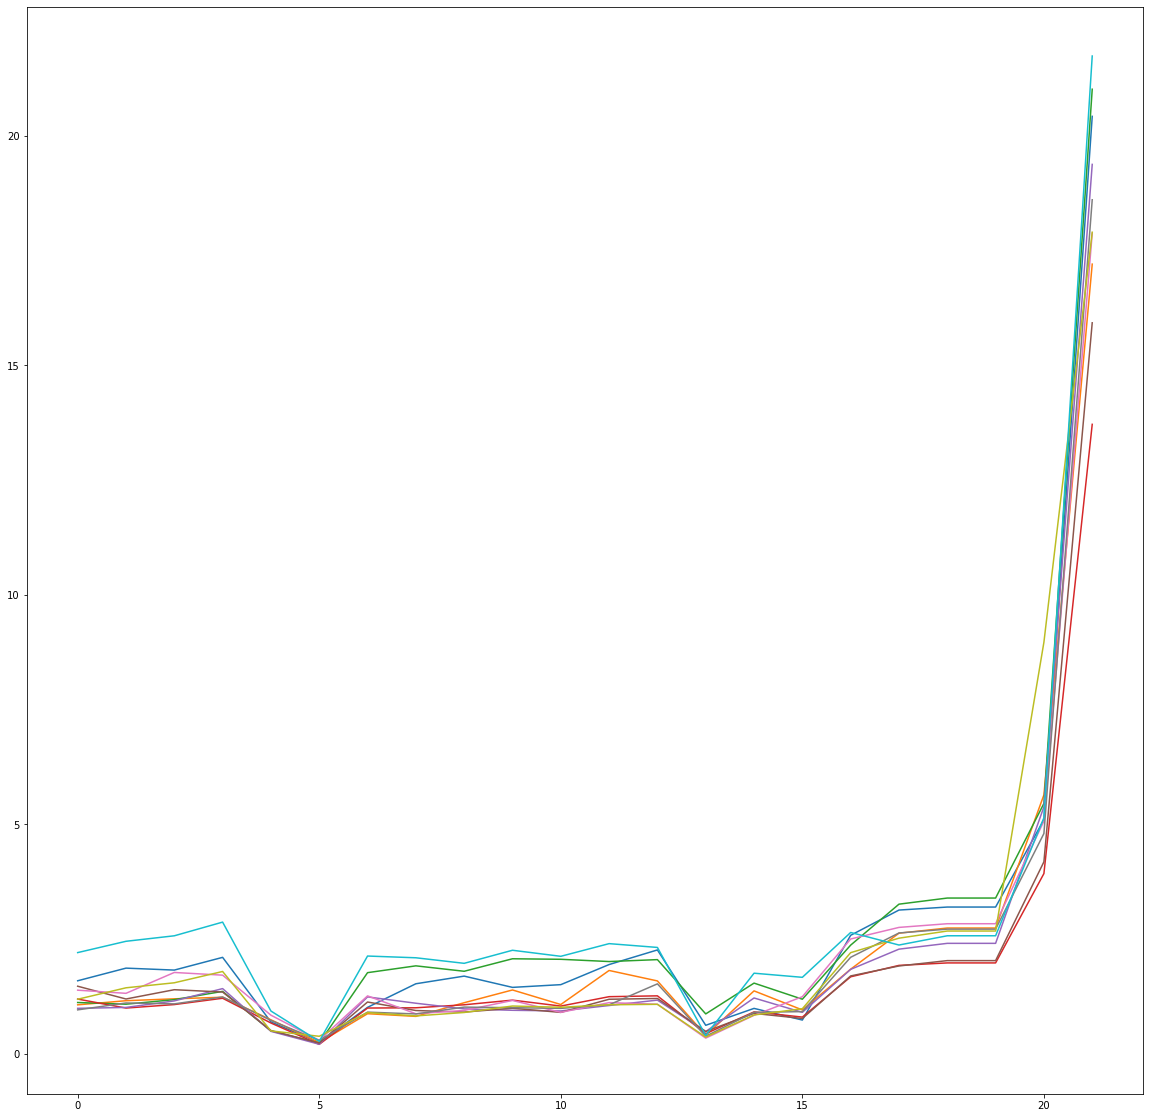

In [14]:
# centroids_each_class_per_layer
distances_between = []
dist_to_other_centroids_per_class_centroid = {val: [] for val in range(num_classes)}

for layer_n in range(len(centroids_each_class_per_layer[0])):
    centroids = [centroids_each_class_per_layer[class_n][layer_n] for class_n in range(num_classes)]
    combos = itertools.combinations(centroids, r=2)
    dist_between = np.linalg.norm([(x0 - x1) for x0, x1 in combos])
    distances_between.append(dist_between)
    
    for class_n in range(num_classes):
        class_centroid = centroids_each_class_per_layer[class_n][layer_n]
        
        _dist = []
        for class_m in range(num_classes):
            if class_m != class_n:
                
                _dist.append(np.linalg.norm(class_centroid - centroids_each_class_per_layer[class_m][layer_n]))
        
        dist_to_other_centroids_per_class_centroid[class_n].append(np.average(_dist))
                
                


fig, axs = plt.subplots(1, 1, figsize=(20, 20))
for class_n in range(num_classes):
    
    axs.plot(dist_to_other_centroids_per_class_centroid[class_n])

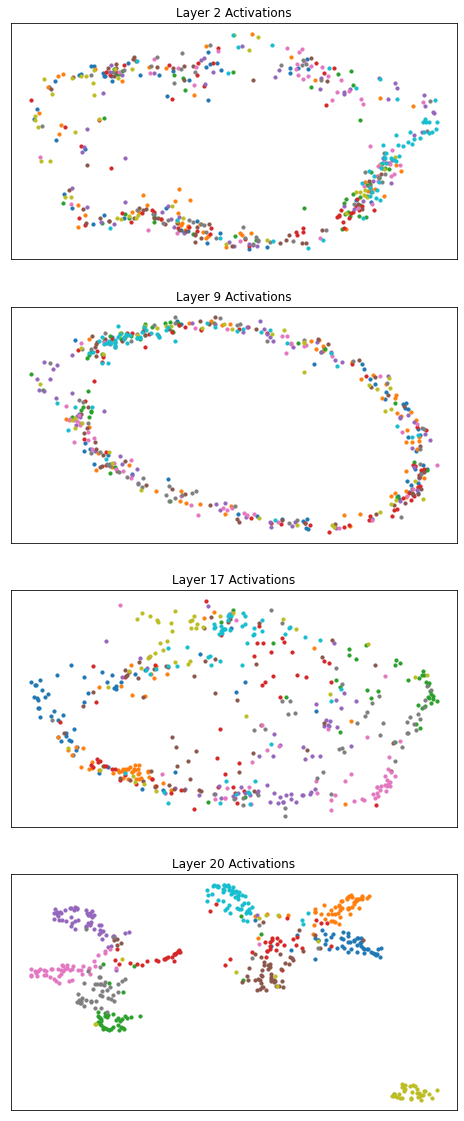

In [15]:
# PLOT OF PROGRESSIVE LAYERS WITH CLUSTERING
layer_n, umap_obj, clustering_obj = layer_embedding_clusters[0]


layers_to_plot = [2, 9, 17, 20]
fix, axs = plt.subplots(len(layers_to_plot), 1, figsize=(8, 20))


y_to_use = y_concepts

for idx, layer in enumerate(layers_to_plot):

    standard_embedding = embedded_activations[layer]
    
    for class_i in range(num_classes):

        class_idxs = np.where(y_concepts == class_i)[0]
#         if layer == 20:
#             print(f"len of class_idxs: {len(class_idxs)}")
        axs[idx].scatter(standard_embedding[:, 0][class_idxs], standard_embedding[:, 1][class_idxs], cmap="Spectral", s=10, label=f"class {class_i}")
        
#         axs[idx].scatter(centroids_each_class_per_layer[class_i][layer][0], centroids_each_class_per_layer[class_i][layer][1], c="black")
    
    axs[idx].set_title(f"Layer {layer} Activations")
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

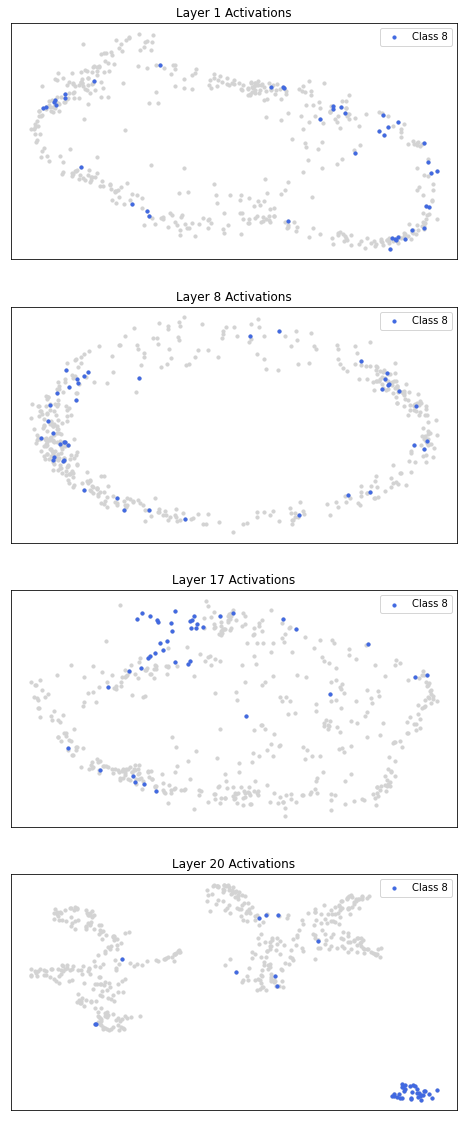

In [16]:
# PLOT OF PROGRESSIVE LAYERING ONLY FOCUSING ON ONE GROUP
layer_n, umap_obj, clustering_obj = layer_embedding_clusters[0]


layers_to_plot = [1, 8, 17, 20]
fix, axs = plt.subplots(len(layers_to_plot), 1, figsize=(8, 20))

data = layer_outputs
target = y_concepts

class_to_examine = 8
idxs_ = np.where(target == class_to_examine)[0]

c_ = np.array(["lightgrey"] * len(target))
c_[idxs_] = "royalblue"

for idx, layer in enumerate(layers_to_plot):

    standard_embedding = embedded_activations[layer]
    axs[idx].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c="lightgrey", s=10, cmap="Spectral", label="_nolegend_")
    axs[idx].scatter(standard_embedding[idxs_][:, 0], standard_embedding[idxs_][:, 1], c="royalblue", s=10, cmap="Spectral", label=f"Class {class_to_examine}")
    
    
    axs[idx].set_title(f"Layer {layer} Activations")
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].legend()
    
#     axs[idx].scatter(centroids_each_class_per_layer[class_to_examine][layer][0], centroids_each_class_per_layer[class_to_examine][layer][1])

# i odnt
# axs[3].scatter(*centroids_each_class_per_layer[2][20], c= "purple")

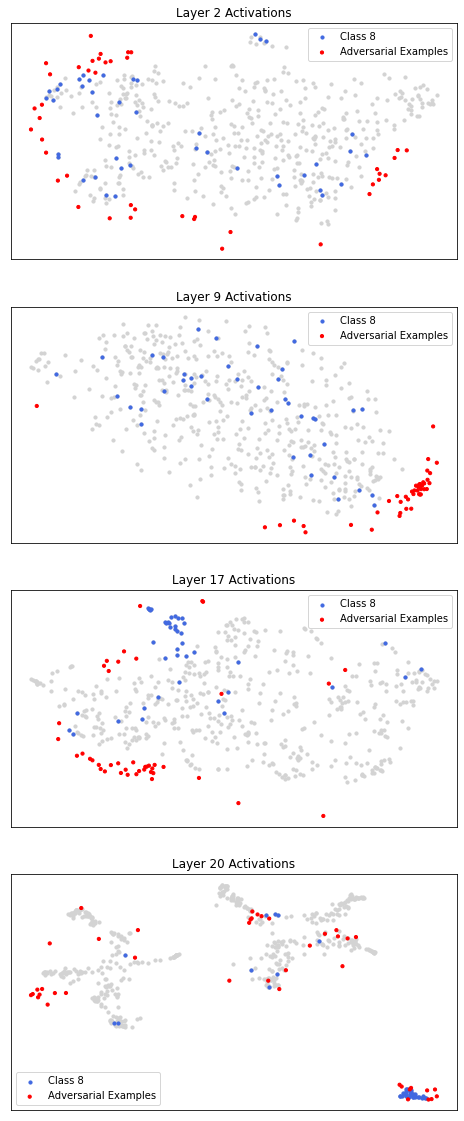

In [17]:
# PLOT OF PROGRESSIVE LAYERING ONLY FOCUSING ON ONE GROUP
layer_n, umap_obj, clustering_obj = layer_embedding_clusters[0]


layers_to_plot = [3, 9, 17, 20]
fix, axs = plt.subplots(len(layers_to_plot), 1, figsize=(8, 20))

data = layer_outputs
target = y_concepts

class_to_examine = 8
idxs_ = np.where(target == class_to_examine)[0]
c_ = np.array(["lightgrey"] * len(target))
c_[idxs_] = "royalblue"

c_adv_ = np.array(["red"] * len(idxs_))


for idx, layer in enumerate(layers_to_plot):
    umap_obj = layer_embedding_clusters[layer][1]
    standard_embedding = umap_obj.transform(flatten(layer_outputs[layer]))
    
    adversarials_to_use = layer_outputs_adv[layer][idxs_]
    standard_embedding_adv = umap_obj.transform(flatten(adversarials_to_use))
    
    axs[idx].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c="lightgrey", s=10, cmap='Spectral', label=f"_nolegend_")
    axs[idx].scatter(standard_embedding[idxs_][:, 0], standard_embedding[idxs_][:, 1], c="royalblue", s=10, cmap="Spectral", label=f"Class {class_to_examine}")
    axs[idx].scatter(standard_embedding_adv[:, 0], standard_embedding_adv[:, 1], c=c_adv_, s=10, cmap='Spectral', label="Adversarial Examples")

    
    axs[idx].set_title(f"Layer {layer} Activations")
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].legend()

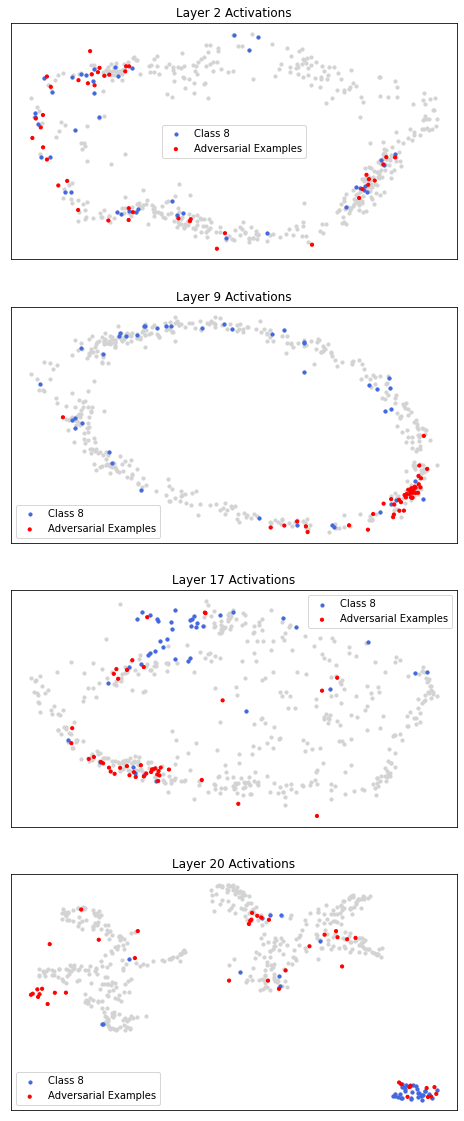

In [18]:
# PLOT OF PROGRESSIVE LAYERING ONLY FOCUSING ON ONE GROUP
layer_n, umap_obj, clustering_obj = layer_embedding_clusters[0]


layers_to_plot = [2, 9, 17, 20]
fix, axs = plt.subplots(len(layers_to_plot), 1, figsize=(8, 20))

data = layer_outputs
target = y_concepts

class_to_examine = 8
idxs_ = np.where(target == class_to_examine)[0]
c_ = np.array(["lightgrey"] * len(target))
c_[idxs_] = "royalblue"

c_adv_ = np.array(["red"] * len(idxs_))

n_sigma = 2
for idx, layer in enumerate(layers_to_plot):
    umap_obj = layer_embedding_clusters[layer][1]
#     standard_embedding = umap_obj.transform(flatten(data[layer]))
    standard_embedding = embedded_activations[layer]
    
    standard_embedding_adv = embedded_activations_adv[layer, idxs_, :]

#     adversarials_to_use = layer_outputs_adv[layer][idxs_]
#     standard_embedding_adv = umap_obj.transform(flatten(adversarials_to_use))
    
    axs[idx].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c="lightgrey", s=10, cmap='Spectral', label=f"_nolegend_")
    axs[idx].scatter(standard_embedding[idxs_][:, 0], standard_embedding[idxs_][:, 1], c="royalblue", s=10, cmap="Spectral", label=f"Class {class_to_examine}")
    axs[idx].scatter(standard_embedding_adv[:, 0], standard_embedding_adv[:, 1], c=c_adv_, s=10, cmap='Spectral', label="Adversarial Examples")
    
    x_ = standard_embedding[idxs_]
#     x1 = standard_embedding[idxs_][:, 1]
#             x_embedded = x_embedded[(abs(x_embedded[:,0] - np.mean(x_embedded[:,0])) < n_sigma * np.std(x_embedded[:,0])) &
#                                 (abs(x_embedded[:,1] - np.mean(x_embedded[:,1])) < n_sigma * np.std(x_embedded[:,1]))]
        
    x_ = x_[(abs(x_[:,0] - np.mean(x_[:,0])) < n_sigma * np.std(x_[:,0])) &
                                (abs(x_[:,1] - np.mean(x_[:,1])) < n_sigma * np.std(x_[:,1]))]
    
    
#     axs[idx].scatter(np.mean(x_[:,0]), np.mean(x_[:,1]),c="black")
#     axs[idx].scatter(centroids_each_class_per_layer[class_to_examine][layer][0], centroids_each_class_per_layer[class_to_examine][layer][1], c="black")
    
    axs[idx].set_title(f"Layer {layer} Activations")
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].legend()

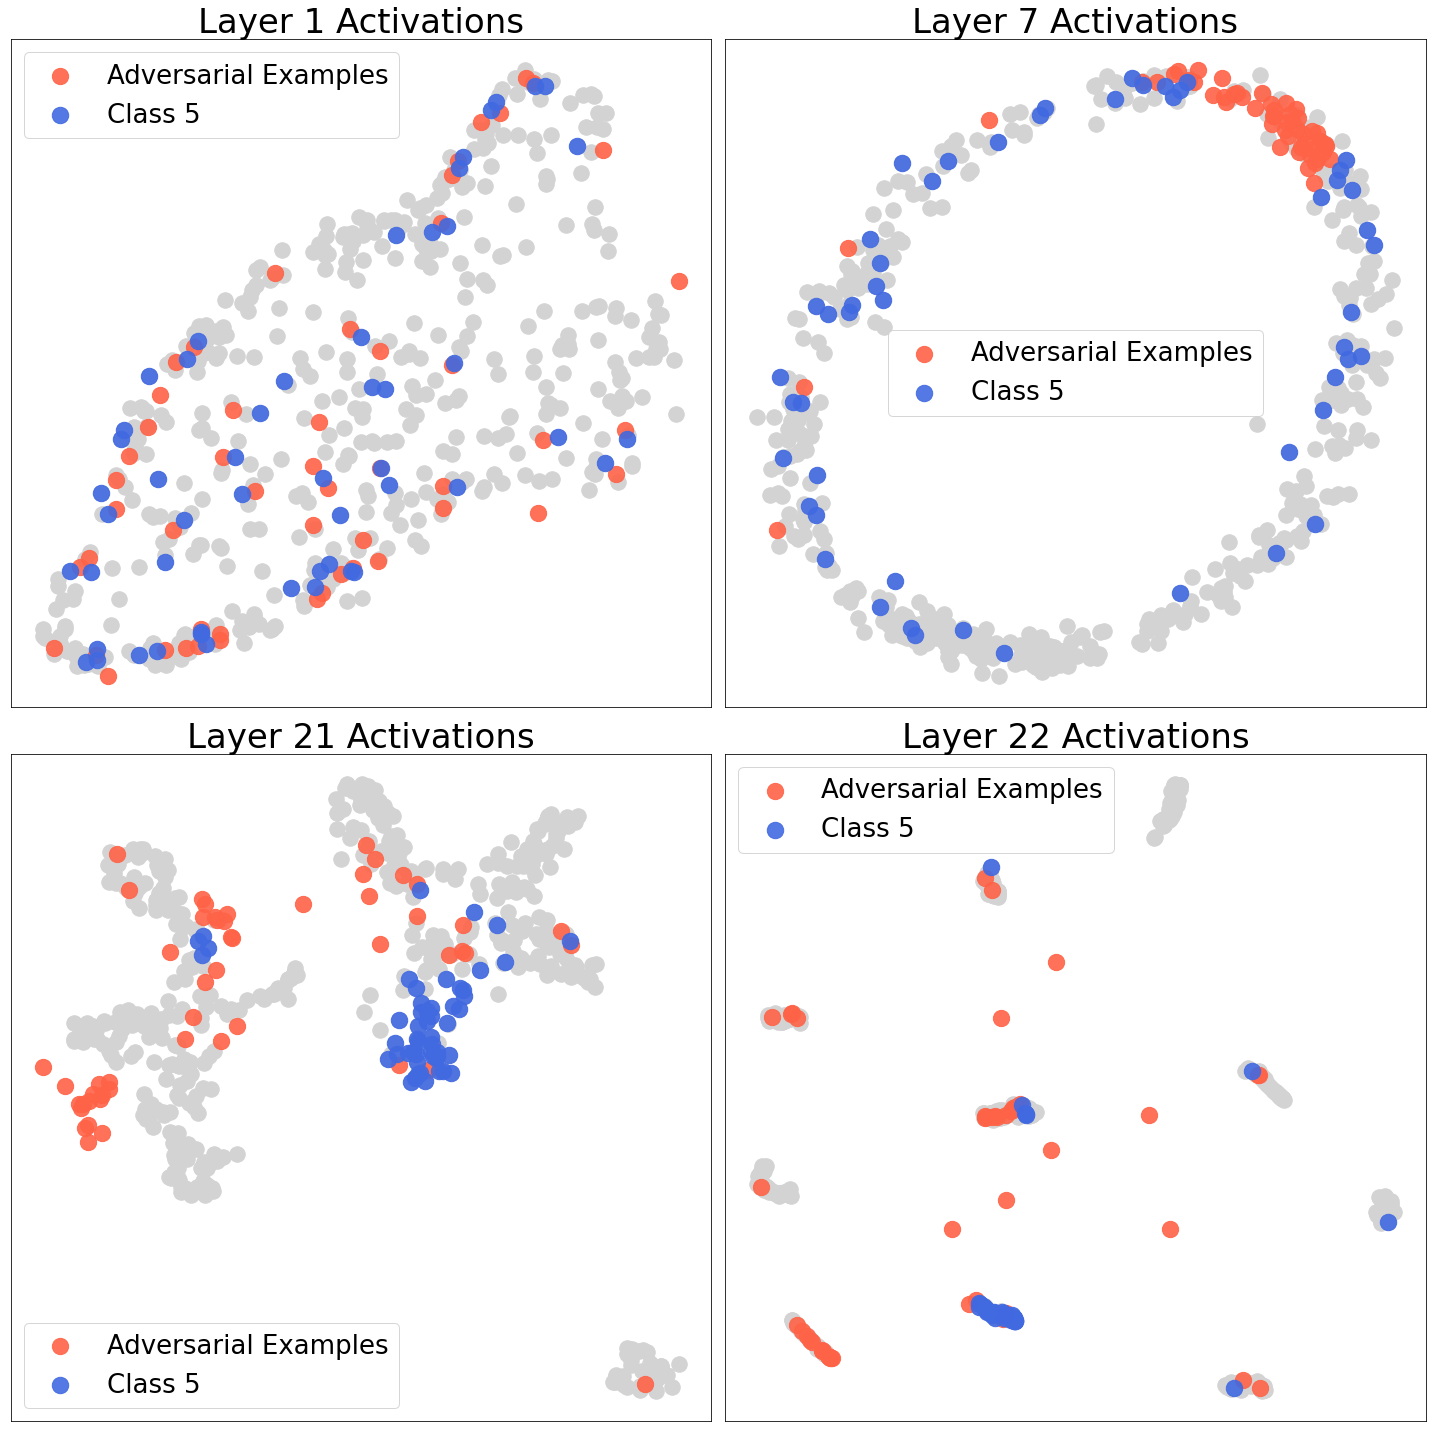

In [66]:
# PLOT OF PROGRESSIVE LAYERING ONLY FOCUSING ON ONE GROUP
layer_n, umap_obj, clustering_obj = layer_embedding_clusters[0]


layers_to_plot = [0, 6, 20, 21]
fix, axs = plt.subplots(2, 2, figsize=(20, 20))

axs = axs.reshape(-1)
data = layer_outputs
target = y_concepts

class_to_examine = 5
idxs_ = np.where(target == class_to_examine)[0]
c_ = np.array(["lightgrey"] * len(target))
c_[idxs_] = "royalblue"

c_adv_ = np.array(["red"] * len(idxs_))

n_sigma = 2
for idx, layer in enumerate(layers_to_plot):
    umap_obj = layer_embedding_clusters[layer][1]
#     standard_embedding = umap_obj.transform(flatten(data[layer]))
    standard_embedding = embedded_activations[layer]
    
    standard_embedding_adv = embedded_activations_adv[layer, idxs_, :]

#     adversarials_to_use = layer_outputs_adv[layer][idxs_]
#     standard_embedding_adv = umap_obj.transform(flatten(adversarials_to_use))
    
    axs[idx].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c="lightgrey", s=240, cmap='Spectral', label=f"_")
    axs[idx].scatter(standard_embedding_adv[:, 0], standard_embedding_adv[:, 1], c="tomato", s=265, cmap='Spectral', label="Adversarial Examples", alpha=0.9)
    axs[idx].scatter(standard_embedding[idxs_][:, 0], standard_embedding[idxs_][:, 1], c="royalblue", s=270, cmap="Spectral", label=f"Class {class_to_examine}", alpha=0.9)
    

    
#     x_ = standard_embedding[idxs_]
    
#     x_ = x_[(abs(x_[:,0] - np.mean(x_[:,0])) < n_sigma * np.std(x_[:,0])) &
#                                 (abs(x_[:,1] - np.mean(x_[:,1])) < n_sigma * np.std(x_[:,1]))]
    
    
    
    axs[idx].set_title(f"Layer {layer+1} Activations", fontsize=34)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
    axs[idx].legend(fontsize=26)
# axs[0].set_title(f"Layer 1 Activations")
plt.tight_layout()

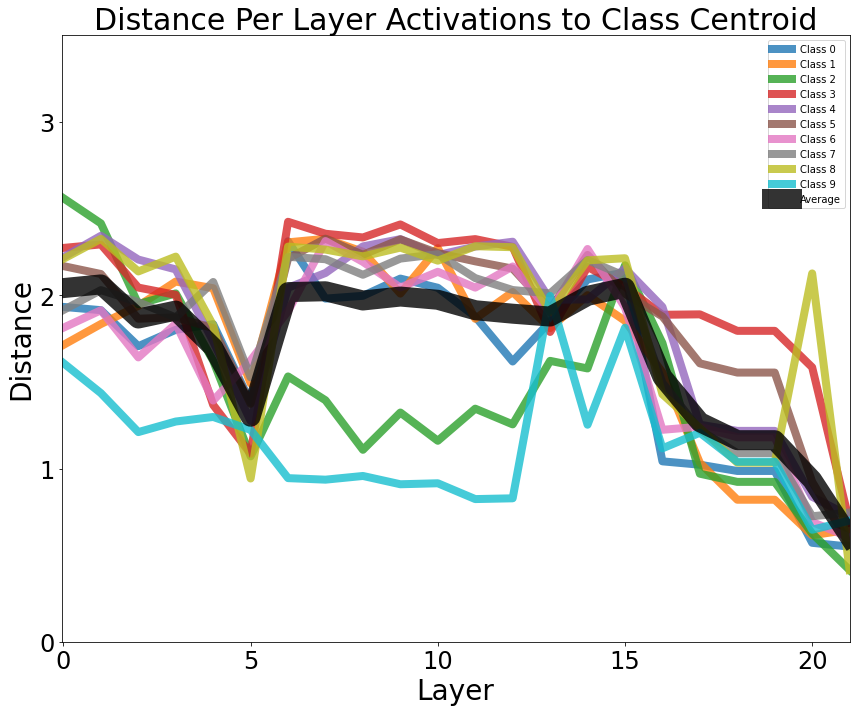

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))

# taking smaller amount since its hard to tell with many
# dont_plot = [0, 1, 2, 3, 4, 5, 6]
dont_plot = []


# calculate averages and standard deviations 

avg_dist = []
avg_std = []

for layer_n in range(len(average_distance_each_class_per_layer[0])):
    distances = [average_distance_each_class_per_layer[class_n][layer_n] for class_n in range(num_classes)]
    avg_dist.append(np.mean(distances))
    avg_std.append(np.std(distances))
    

for class_label, distances in average_distance_each_class_per_layer.items():
#     if class_label in dont_plot:
#         continue
    axs.plot(distances, label=f"Class {class_label}", alpha=0.8, linewidth=8)
    
# axs.plot(avg)
axs.plot(avg_dist, linewidth=20, alpha=0.8, label="Average", color="black")
# std_above= [avg_dist[idx] + (2 * val) for idx, val in enumerate(avg_std)]
# std_below= [avg_dist[idx] - (2 * val) for idx, val in enumerate(avg_std)]
# axs.plot(std_above)
# axs.plot(std_below)
    
axs.set_xticks([val for val in range(0, 21, 5)])
axs.set_xticklabels([val for val in range(0, 21, 5)], fontsize=24)
axs.set_yticks(range(5))
axs.set_yticklabels(range(5), fontsize=24)

axs.set_xlabel(f"Layer", fontsize=28)
axs.set_ylabel(f"Distance", fontsize=28)
axs.set_title("Distance Per Layer Activations to Class Centroid", fontsize=30)
axs.set_ylim(bottom=0.0, top=3.5)
axs.set_xlim(left=-0.05, right=21.)
# axs.legend([f"Class {x}" for x in range(9)])



axs.legend()
plt.tight_layout()    


In [21]:
def should_filter_(x, y_true, model, standard_embedding, layer_embedding_clusters, centroids, std):
    activations = generate_layer_outputs(np.expand_dims(x, axis=0), model)
    preds = activations[len(model.layers) - 1]
    pred_class = preds.argmax()
    
    near_centroid_arr = []
    
    for layer_n, layer_activations in activations.items():
        umap_obj = layer_embedding_clusters[layer_n][1]
#         standard_embedding = 
#         standard_embedding = umap_obj.transform(flatten(layer_activations))
        
        centroid = centroids_each_class_per_layer[pred_class][layer_n]
        std = std_each_class_per_layer[pred_class][layer_n]
        
        near_centroid = 1
        if False in (np.abs(standard_embedding - centroid) < 1 * std)[0]:
            near_centroid = 0
#         print(near_centroid, (np.abs(standard_embedding - centroid) < 1 * std))
        
        near_centroid_arr.append(near_centroid)
        
    return near_centroid_arr, preds

In [22]:
def should_filter_std(embedded_acts, y_pred, n_sigma=1):
    y_pred_class = y_pred.argmax()
    centroids = centroids_each_class_per_layer[y_pred_class]
    
    near_centroid_arr = []
    for layer_n in range(len(embedded_acts)):
        
        x0 = embedded_acts[layer_n]        
        predicted_centroid = centroids_each_class_per_layer[y_pred_class][layer_n]
        
        within_bounds = np.abs(x0 - predicted_centroid) < n_sigma * embedded_std[y_pred_class][layer_n][0]
#         breakpoint()
        if False in within_bounds:
            near_centroid_arr.append(1)
        else:
            near_centroid_arr.append(0)
#         print(near_centroid_arr, tmp)
        
    return near_centroid_arr
    

def should_filter_closest(embedded_acts, y_preds):
    y_pred_class = y_preds.argmax()
    centroids = centroids_each_class_per_layer[y_pred_class]
    
    near_centroid_arr = []
    for layer_n in range(len(embedded_acts)):
        
        x0 = embedded_acts[layer_n]
        
        centroids = [centroids_each_class_per_layer[class_n][layer_n] for class_n in range(num_classes)]
        
        
        dist_to_centroids = np.array([np.linalg.norm(x0 - c) for c in centroids])
        closest_centroid = dist_to_centroids.argmin()
        
        
        if closest_centroid != y_pred_class:
            near_centroid_arr.append(1)
        else:
            near_centroid_arr.append(0)
    
#     print(f"y_pred_class={y_pred_class}, dist_to_centroids: {dist_to_centroids}")

    return near_centroid_arr
        

In [23]:
misclassified_normal = []
misclassified_adv = []


arr_normal_preds = []
arr_adv_preds = []

arr_ratio_normal = []
arr_ratio_adv = []

# 
embedded_activations_to_use = embedded_activations_subset
embedded_activations_to_use_adv = embedded_activations_subset_adv

activations_to_use = layer_outputs_subset
activations_to_use_adv = layer_outputs_subset_adv

y_to_use = y_concepts_subset

for idx in range(len(activations_to_use[21])):
    y_true = y_to_use[idx]
    
    # compute normal
    pred_normal = activations_to_use[21][idx]
    pred_class_normal = pred_normal.argmax()
    near_centroid_arr_normal = should_filter_std(embedded_activations_to_use[:, idx,: ], pred_normal)
#     near_centroid_arr_normal = should_filter_closest(embedded_activations_to_use_adv[:, idx,: ], pred_adv)

    #  near_centroid_arr_normal, _ = should_filter_(x_concepts_subset[idx], y_true, model, embedded_activations_subset[:, idx, :], layer_embedding_clusters, centroids_each_class_per_layer, std_each_class_per_layer)
#     ratio_normal = np.average(near_centroid_arr_normal, weights=np.exp(range(len(model.layers))))
    ratio_normal = np.average(near_centroid_arr_normal, weights=range(len(model.layers)))
    
    arr_ratio_normal.append(ratio_normal)
    arr_normal_preds.append(pred_normal.max())
    
    # SWITCHING THESE BUT     
    if pred_class_normal != y_true:
        misclassified_normal.append(1)
    else:
        misclassified_normal.append(0)
    
    

for idx in range(len(activations_to_use_adv[21])):
    y_true = y_to_use[idx]
    pred_adv = activations_to_use_adv[21][idx]
    pred_class_adv = pred_adv.argmax()
    
    # only do this      
    if y_true == pred_class_adv:
        continue
    near_centroid_arr_adv = should_filter_std(embedded_activations_to_use_adv[:, idx,: ], pred_adv)
#     near_centroid_arr_adv = should_filter_closest(embedded_activations_to_use_adv[:, idx,: ], pred_adv)
    
#     near_centroid_arr_adv, _ = should_filter_(x_concepts_subset_attack[idx], y_true, model, embedded_activations_subset_adv[:, idx, :], layer_embedding_clusters, centroids_each_class_per_layer, std_each_class_per_layer)
#     ratio_adv = np.average(near_centroid_arr_adv, weights = np.exp(range(len(model.layers))))
    ratio_adv = np.average(near_centroid_arr_adv, weights = range(len(model.layers)))

    
    arr_ratio_adv.append(ratio_adv)
    arr_adv_preds.append(pred_adv.max())
    
    
    if pred_class_adv != y_true:
        misclassified_adv.append(1)
    else:
        misclassified_adv.append(0)
        


<ipython-input-36-20980624c87e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
<ipython-input-36-20980624c87e>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)


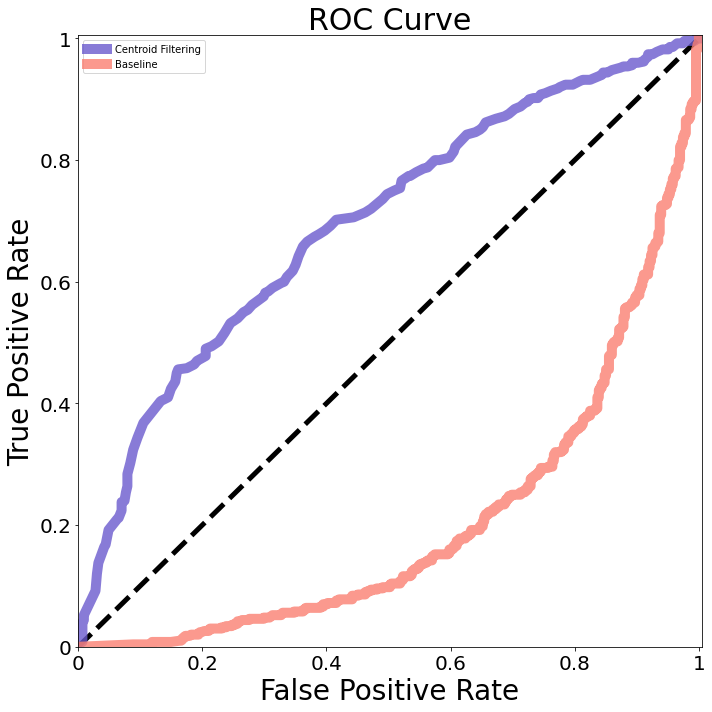

In [36]:

fpr_filtering, tpr_filtering, thresholds_filtering = metrics.roc_curve(misclassified_normal + misclassified_adv,  arr_ratio_normal + arr_ratio_adv)
# fpr_filtering, tpr_filtering, thresholds_filtering = metrics.roc_curve(misclassified_normal,  arr_ratio_normal)
# fpr_filtering, tpr_filtering, thresholds_filtering = metrics.roc_curve(misclassified_adv,  arr_ratio_adv)

fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(misclassified_normal + misclassified_adv, arr_normal_preds + arr_adv_preds)
# fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(misclassified_normal, arr_normal_preds)
# fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(misclassified_adv, arr_adv_preds)


roc_auc = metrics.auc(fpr_filtering, tpr_filtering)

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

axs.plot([0, 1], [0, 1], 'k--', linewidth=5.0)
axs.plot(fpr_filtering, tpr_filtering, label="Centroid Filtering", c="slateblue", linewidth=10, alpha=0.8)
axs.plot(fpr_baseline, tpr_baseline, label="Baseline", c="salmon", linewidth=10, alpha=0.8)
# # # axs.plot(fpr_normal, tpr_normal, label="Filtering Only Normal Images")

axs.set_xbound(lower=0.0, upper=1.005)
axs.set_ybound(lower=0.0, upper=1.005)
axs.set_xlabel("False Positive Rate", fontsize=28)
axs.set_ylabel("True Positive Rate", fontsize=28)
axs.set_title("ROC Curve", fontsize=30)

axs.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
axs.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
axs.legend()

# roc_display = metrics.RocCurveDisplay(fpr=fpr_filtering, tpr=tpr_filtering, roc_auc=roc_auc, estimator_name="Centroid Filtering")
# roc_display.plot()
plt.tight_layout()
plt.show()


(1000, 10)

In [42]:
clustering = cluster.SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0)
clustering_fit = clustering.fit(np.concatenate((layer_outputs[21], layer_outputs_adv[21])))
pred

In [45]:
clustering_fit.fit_predict(np.concatenate((layer_outputs[21][0:10], layer_outputs_adv[21][0:10])))

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [35]:
metrics.auc(fpr_filtering, tpr_filtering), metrics.auc(fpr_baseline, tpr_baseline)

(0.6945210280373832, 0.20234579439252337)

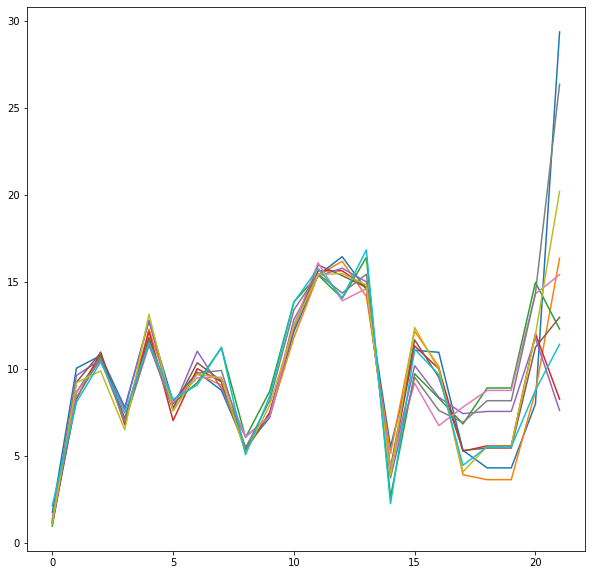

In [460]:
avg_distance_to_other_clusters = {val: [] for val in range(num_classes)}

for class_n in range(num_classes):
    centroids_for_curr_class = centroids_each_class_per_layer[class_n]
    for layer_n in range(len(centroids_each_class_per_layer[class_n])):
        centroid = centroids_for_curr_class[layer_n]

        other_centroids = [centroids_each_class_per_layer[n][0] for n in range(len(centroids_each_class_per_layer)) if n != class_n]
        avg = np.mean([np.linalg.norm(centroid - x) for x in other_centroids])
        avg_distance_to_other_clusters[class_n].append(avg)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

for class_n in range(num_classes):
    dist = avg_distance_to_other_clusters[class_n]
    ax.plot(dist, label=f"class {class_n}")

In [659]:
# TODO:  TRACK  MISCLASSIFIED  IMAGE  VS  IMAGE OF CORRECT CLASS]
#     ⇒[TODO:  PLOT  OF  AVERAGE  DISTANCE  FOR  AD-VERSARIAL VS CORRECTLY CLASSIFIED IMAGES

# 1.  get group of misclassified (and non adv) with predicted class N, get group of correctly classified from class N
# plot distance

class_to_ex = 3

bad_avgs = []
good_avgs = []

bad_classified_idxs = []
good_classified_idxs = []

bad_distances_to_centroid = []
good_distances_to_centroid = []

correct_exs = np.where(y_concepts == class_to_ex)[0]

for i in np.where(layer_outputs[21].argmax(axis=1) == class_to_ex)[0]:
    if i in correct_exs:
        good_classified_idxs.append(i)
    else: 
        bad_classified_idxs.append(i)
    
# for each layer calculate
for layer_n, umap_obj, clustering_obj in layer_embedding_clusters:
    
    centroid = centroids_each_class_per_layer[class_to_ex][layer_n]
    
    # get misclassified 
    x = layer_outputs[layer_n][bad_classified_idxs]
    x_embedded = umap_obj.transform(flatten(x))
    
    bad_distances_to_centroid.append([np.linalg.norm(centroid - point) for point in x_embedded])
#     bad_avgs.append(np.mean(bad_distances_to_centroid))
    
    # get distances when its a good classificaiton 
    x = layer_outputs[layer_n][good_classified_idxs]
    x_embedded = umap_obj.transform(flatten(x))
    
    good_distances_to_centroid.append([np.linalg.norm(centroid - point) for point in x_embedded])
    good_avgs.append(np.mean(good_distances_to_centroid[-1]))
    
    

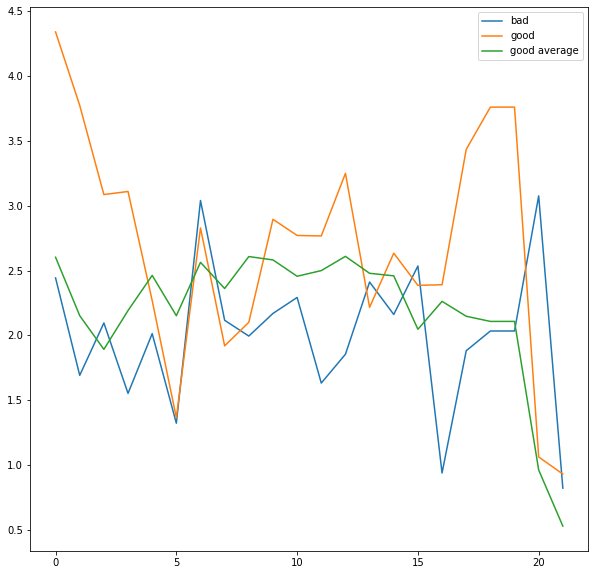

In [666]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.plot([val[0] for val in bad_distances_to_centroid], label="bad")
axs.plot([val[0] for val in good_distances_to_centroid], label="good")
axs.plot(good_avgs, label="good average")
axs.legend()

In [674]:
#     ⇒[TODO:  PLOT  OF  AVERAGE  DISTANCE  FOR  AD-VERSARIAL VS CORRECTLY CLASSIFIED IMAGES

# 1.  get group of misclassified (and non adv) with predicted class N, get group of correctly classified from class N
# plot distance

# USES LAYER_OUTPUTS/LAYER_OUTPUTS_ADV WITH Y_CONCEPTS

class_to_ex = 3

adv_avgs = []
good_avgs = []

adv_classified_idxs = []
bad_classified_idxs = []
good_classactivationsdxs = []

bad_distances_to_centroid = []
good_distances_to_centroid = []
adv_distances_to_centroid = []

correct_exs = np.where(y_concepts == class_to_ex)[0]

for i in np.where(layer_outputs_adv[21].argmax(axis=1) == class_to_ex)[0]: 
    if i not in correct_exs:
        adv_classified_idxs.append(i)

for i in np.where(layer_outputs[21].argmax(axis=1) == class_to_ex)[0]:
    if i in correct_exs:
        good_classified_idxs.append(i)
    else: 
        bad_classified_idxs.append(i)
    
# for each layer calculate
for layer_n, umap_obj, clustering_obj in layer_embedding_clusters:
    
    centroid = centroids_each_class_per_layer[class_to_ex][layer_n]
    
    x = layer_outputs_adv[layer_n][adv_classified_idxs]
    x_embedded = umap_obj.transform(flatten(x))
    adv_distances_to_centroid.append([np.linalg.norm(centroid - point) for point in x_embedded])
    
    # get misclassified 
    x = layer_outputs[layer_n][bad_classified_idxs]
    x_embedded = umap_obj.transform(flatten(x))
    
    bad_distances_to_centroid.append([np.linalg.norm(centroid - point) for point in x_embedded])
#     bad_avgs.append(np.mean(bad_distances_to_centroid))
    
    # get distances when its a good classificaiton 
    x = layer_outputs[layer_n][good_classified_idxs]
    x_embedded = umap_obj.transform(flatten(x))
    
    good_distances_to_centroid.append([np.linalg.norm(centroid - point) for point in x_embedded])
    good_avgs.append(np.mean(good_distances_to_centroid[-1]))
    
    

In [741]:
def get_distances_to_correct_and_predicted(
    n_idx,
    data_to_use,
    orig_y,
):

    prediction_output = data_to_use[21][n_idx]
    pred_class = prediction_output.argmax()
    y_true = orig_y[n_idx]

    activations_ = {k: v[n_idx] for k, v in data_to_use.items()}

    distance_to_classified_centroid = []
    distance_to_correct_centroid = []

    for layer_n, umap_obj, clustering_obj in layer_embedding_clusters:
        activations = activations_[layer_n]
        x_embedded = umap_obj.transform(flatten(activations, 1))

        correct_centroid = centroids_each_class_per_layer[y_true][layer_n]
        predicted_centroid = centroids_each_class_per_layer[pred_class][layer_n]

        distance_to_classified_centroid.append(np.linalg.norm(predicted_centroid - x_embedded))
        distance_to_correct_centroid.append(np.linalg.norm(correct_centroid - x_embedded))
    return distance_to_correct_centroid, distance_to_classified_centroid

def get_distances(n_idx):
    return get_distances_to_correct_and_predicted(n_idx, data_to_use=layer_outputs_subset, orig_y=y_concepts_subset)

def get_distances_adv(n_idx):
    return get_distances_to_correct_and_predicted(n_idx, data_to_use=layer_outputs_subset_adv, orig_y=y_concepts_subset)

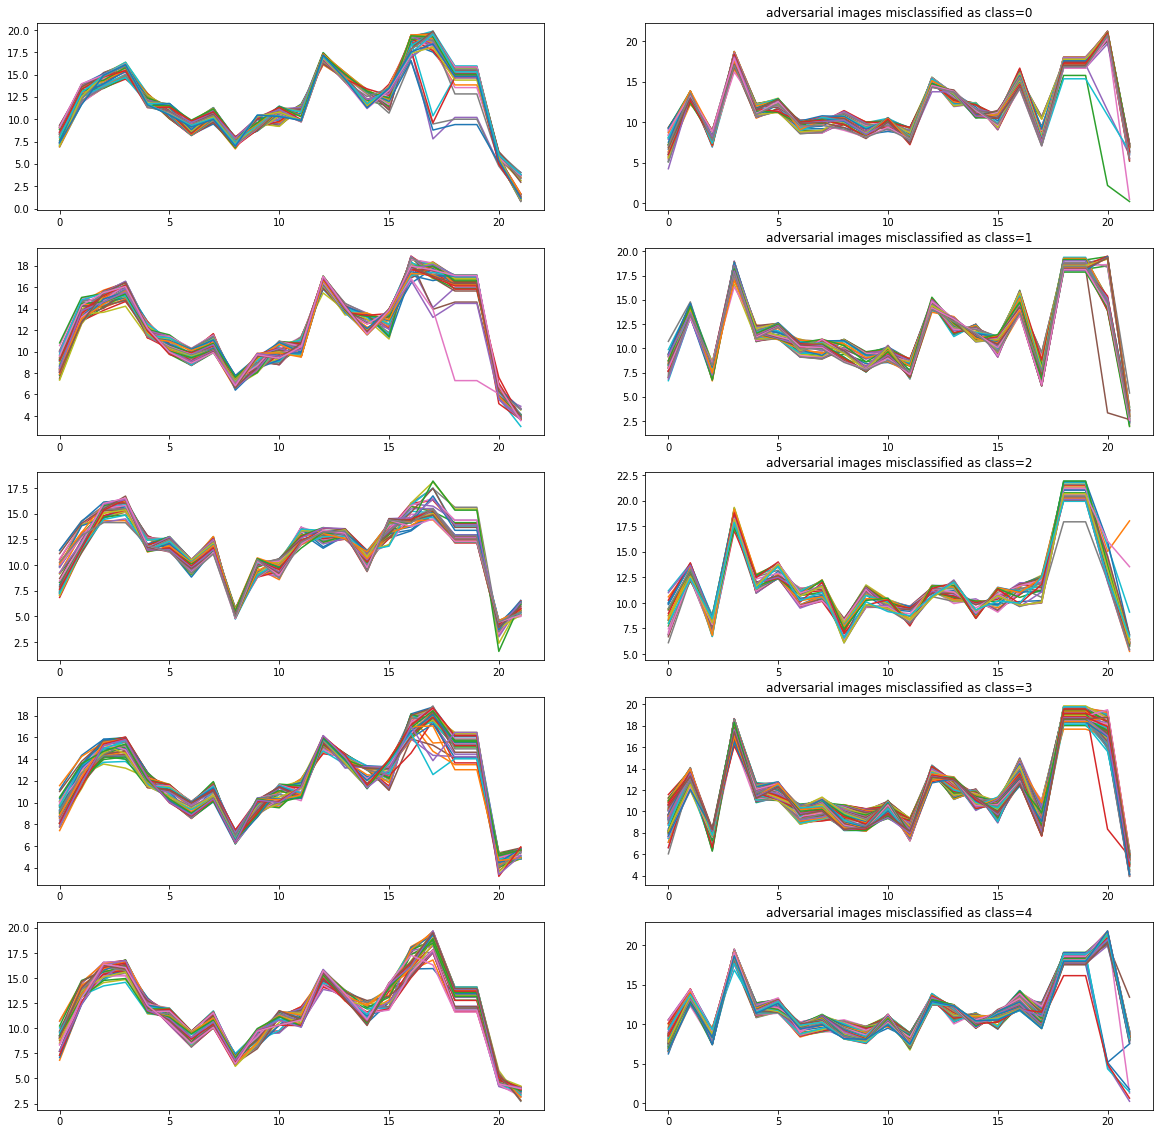

In [50]:
def distance_between(embedded_points, centroids):
    return np.linalg.norm(centroids - embedded_points, axis=1)

normal_correct_distances = {val: [] for val in range(num_classes)}
adv_misclassified_distances = {val: [] for val in range(num_classes)}


data = embedded_activations_subset
adv_data = embedded_activations_subset_adv
data_outputs = layer_outputs_subset[21]
data_outputs_adv = layer_outputs_subset_adv[21]

y_use = y_concepts_subset

for idx, pred in enumerate(data_outputs):
    pred_class = pred.argmax()
    y_true = y_use[idx]

    if pred_class == y_true:
        normal_correct_distances[pred_class].append(distance_between(data[:, idx, :], centroids_each_class_per_layer[pred_class]))


for idx, pred in enumerate(data_outputs_adv):
    pred_class = pred.argmax()
    y_true = y_use[idx]
    
    if pred_class != y_true:
        adv_misclassified_distances[pred_class].append(distance_between(adv_data[:, idx, :], centroids_each_class_per_layer[pred_class]))

        
        
        
        
# fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# for i in range(10):
#     axs[0].plot(np.average(normal_correct_distances[i], axis=0), label=i)
# #     axs[1].plot(np.average(adv_misclassified_distances[i], axis=0), label=i)

# for i, d in enumerate(adv_misclassified_distances[2]):
#     axs[1].plot(d)
# axs[0].legend()
# axs[1].legend()




fig, axs = plt.subplots(5, 2, figsize=(20, 20))

for class_to_show in range(5):
    for i, d in enumerate(normal_correct_distances[class_to_show]):
        axs[class_to_show, 0].plot(d)

    for i, d in enumerate(adv_misclassified_distances[class_to_show]):
        axs[class_to_show, 1].plot(d)
        axs[class_to_show, 1].set_title(f"adversarial images misclassified as class={class_to_show}")

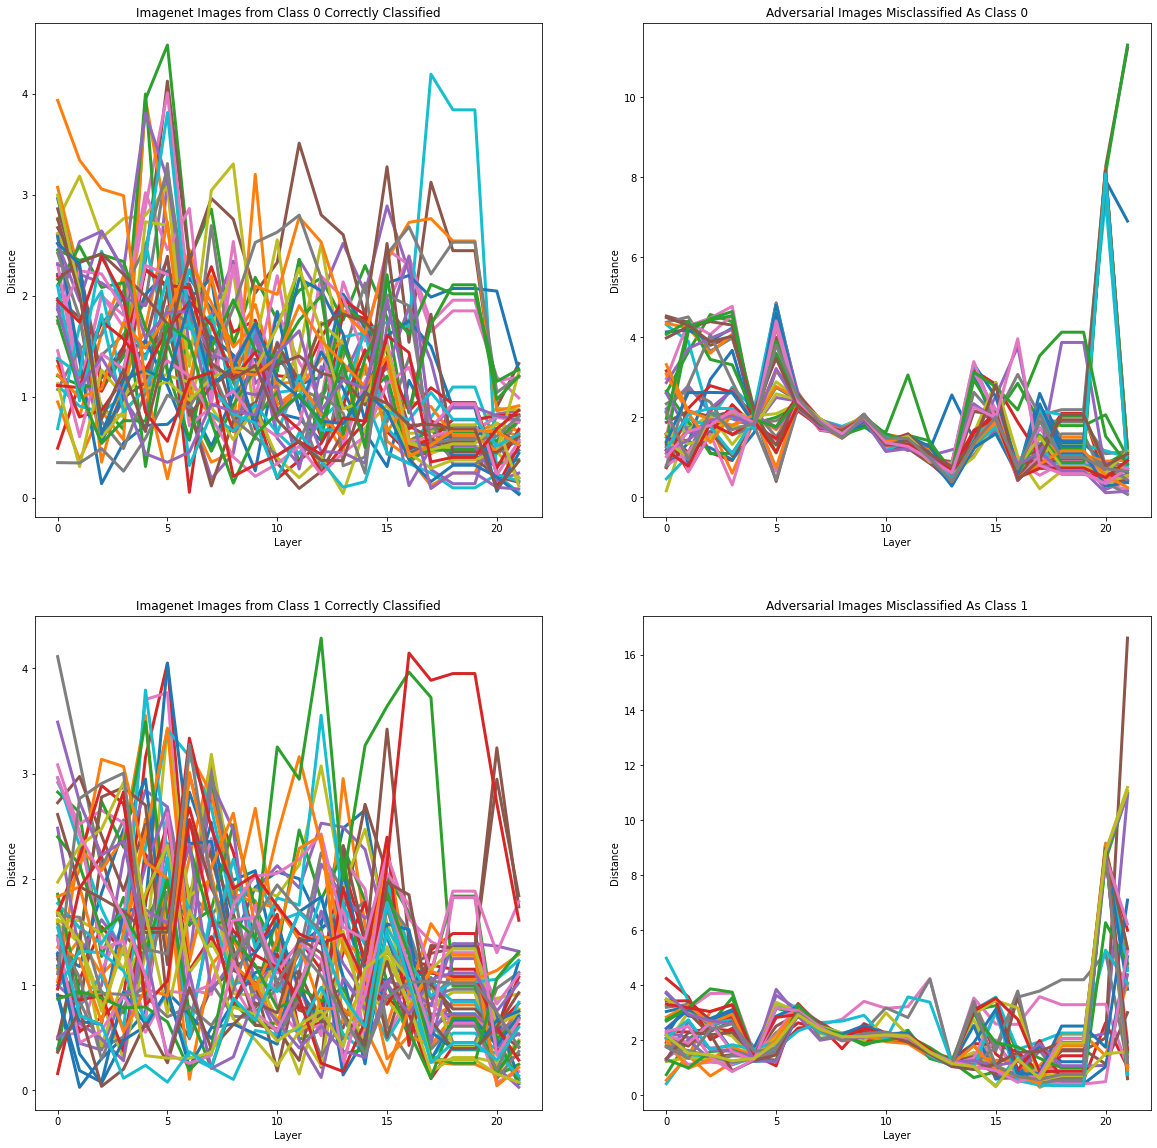

In [241]:
def distance_between(embedded_points, centroids):
    return np.linalg.norm(centroids - embedded_points, axis=1)

correct_distances = {val: [] for val in range(num_classes)}
test_correct_distances = {val: [] for val in range(num_classes)}
adv_misclassified_distances = {val: [] for val in range(num_classes)}
adv_misclassified_distances_subset = {val: [] for val in range(num_classes)}

all_other_distances = {val: [] for val in range(num_classes)}
all_other_distances_subset = {val: [] for val in range(num_classes)}
all_other_distances_adv = {val: [] for val in range(num_classes)}
all_other_distances_subset_adv = {val: [] for val in range(num_classes)}



for idx, pred in enumerate(layer_outputs[21]):
    pred_class = pred.argmax()
    y_true = y_concepts[idx]

    if pred_class == y_true:
        correct_distances[pred_class].append(distance_between(embedded_activations[:, idx, :], centroids_each_class_per_layer[pred_class]))


for idx, pred in enumerate(layer_outputs_adv[21]):
    pred_class = pred.argmax()
    y_true = y_concepts[idx]
    
    if pred_class != y_true:
        adv_misclassified_distances[pred_class].append(distance_between(embedded_activations_adv[:, idx, :], centroids_each_class_per_layer[pred_class]))


for idx, pred in enumerate(layer_outputs_subset[21]):
    pred_class = pred.argmax() 
    y_true = y_concepts_subset[idx]
    
    if pred_class == y_true:
        test_correct_distances[pred_class].append(distance_between(embedded_activations_subset[:, idx, :], centroids_each_class_per_layer[pred_class]))


for idx, pred in enumerate(layer_outputs_subset_adv[21]):
    pred_class = pred.argmax() 
    y_true = y_concepts_subset[idx]
    
    if pred_class != y_true:
        adv_misclassified_distances_subset[pred_class].append(distance_between(embedded_activations_subset_adv[:, idx, :], centroids_each_class_per_layer[pred_class]))


        
# PLOT
# fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# for i in range(10):
#     axs[0].plot(np.average(normal_correct_distances[i], axis=0), label=i)
#     axs[1].plot(np.average(adv_misclassified_distances[i], axis=0), label=i)
# axs[0].legend()
# axs[1].legend()



fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for class_to_show in range(len(axs)):
    for i, d in enumerate(train_correct_distances[class_to_show]):
        axs[class_to_show, 0].plot(d, linewidth=3)
        axs[class_to_show, 0].set_title(f"Imagenet Images from Class {class_to_show} Correctly Classified")
        axs[class_to_show, 0].set_xlabel(f"Layer")
        axs[class_to_show, 0].set_ylabel(f"Distance")

    for i, d in enumerate(adv_misclassified_distances[class_to_show]):
        axs[class_to_show, 1].plot(d, linewidth=3)
        axs[class_to_show, 1].set_title(f"Adversarial Images Misclassified As Class {class_to_show}")
        axs[class_to_show, 1].set_xlabel(f"Layer")
        axs[class_to_show, 1].set_ylabel(f"Distance")

# axs[0].legend()
# axs[1].legend()

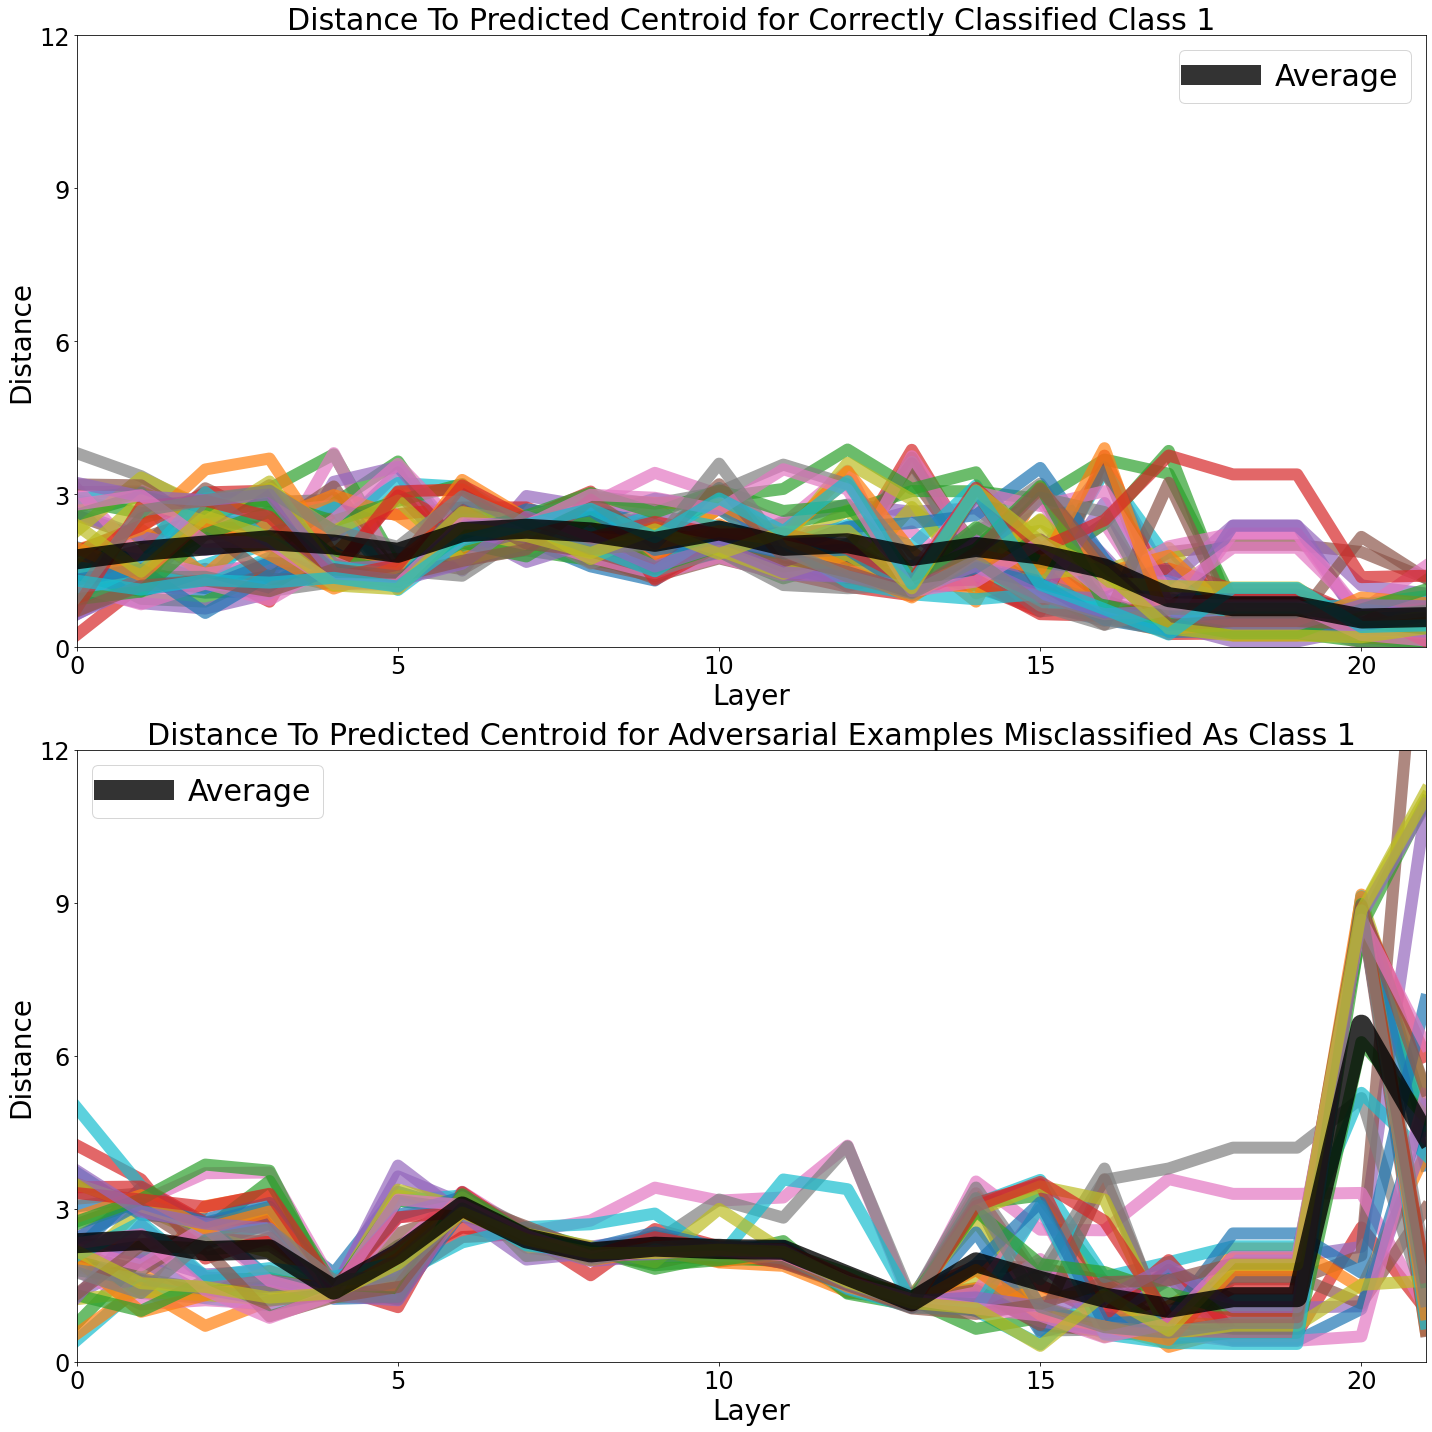

In [454]:

fig, axs = plt.subplots(2, 1, figsize=(20, 20))

class_to_show = 1
for line in correct_distances[class_to_show]:
    axs[0].plot(line, linewidth=12, alpha=0.7)
    
# for line in test_correct_distances[class_to_show]:
#     axs[1].plot(line, linewidth=5, alpha=0.7)
    
    
for line in adv_misclassified_distances[class_to_show]:
    axs[1].plot(line, linewidth=12, alpha=0.7)
    
axs[0].plot(np.mean(correct_distances[class_to_show], axis=0), linewidth=20, alpha=0.8, c="black", label="Average")
axs[1].plot(np.mean(adv_misclassified_distances[class_to_show], axis=0), linewidth=20, alpha=0.8, c="black", label="Average")    

axs[0].set_title(f"Distance To Predicted Centroid for Correctly Classified Class {class_to_show}", fontsize=30)
axs[1].set_title(f"Distance To Predicted Centroid for Adversarial Examples Misclassified As Class {class_to_show}", fontsize=30)


for i in range(2):
    axs[i].set_xlabel(f"Layer", fontsize=28)
    axs[i].set_ylabel(f"Distance", fontsize=28)

for i in range(len(axs)):
    axs[i].set_xticks([0, 5, 10, 15, 20])
    axs[i].set_xticklabels([0, 5, 10, 15, 20], fontsize=24)
    
    axs[i].set_yticks(range(0,13, 3))
    axs[i].set_yticklabels(range(0,13, 3), fontsize=24)
    axs[i].set_xlim(left=0, right=21)
    axs[i].set_ylim(top=12, bottom=0)
    axs[i].legend(fontsize=30)
    
plt.tight_layout()


# axs[1].set_ylim(top=15, bottom=0)

# for class_to_show in range(len(axs)):
#     for i, d in enumerate(normal_correct_distances[class_to_show]):
#         axs[class_to_show, 0].plot(d, linewidth=3)
#         axs[class_to_show, 0].set_title(f"Imagenet Images from Class {class_to_show} Correctly Classified")
#         axs[class_to_show, 0].set_xlabel(f"Layer")
#         axs[class_to_show, 0].set_ylabel(f"Distance")

#     for i, d in enumerate(adv_misclassified_distances[class_to_show]):
#         axs[class_to_show, 1].plot(d, linewidth=3)
#         axs[class_to_show, 1].set_title(f"Adversarial Images Misclassified As Class {class_to_show}")
#         axs[class_to_show, 1].set_xlabel(f"Layer")
#         axs[class_to_show, 1].set_ylabel(f"Distance")

In [770]:

distances_to_correct_centroids = []
distances_to_correct_centroids_adv = []

distances_to_predicted_centroids = []
distances_to_predicted_centroids_adv = []

distances_to_correct_centroids_subset = []
distances_to_correct_centroids_subset_adv = []

distances_to_predicted_centroids_subset = []
distances_to_predicted_centroids_subset_adv = []


embe

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [ ]:
np.save("data/distances_to_correct_centroids", distances_to_correct_centroids)
np.save("data/distances_to_predicted_centroids", distances_to_predicted_centroids)

np.save("data/distances_to_correct_centroids_adv", distances_to_correct_centroids_adv)
np.save("data/distances_to_predicted_centroids_adv", distances_to_predicted_centroids_adv)


np.save("data/distances_to_correct_centroids_subset", distances_to_correct_centroids_subset)
np.save("data/distances_to_predicted_centroids_subset", distances_to_predicted_centroids_subset)

np.save("data/distances_to_correct_centroids_subset_adv", distances_to_correct_centroids_subset_adv)
np.save("data/distances_to_predicted_centroids_subset_adv", distances_to_predicted_centroids_subset_adv)


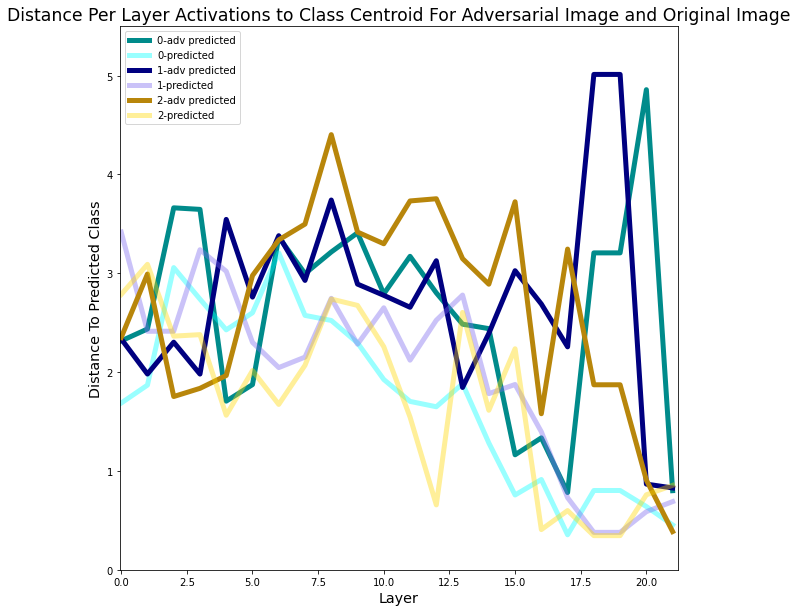

In [748]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

# Not entirely sure if this makes sense since im comparing the adversarial image that is misclassified to its comparable result

# axs.plot(distance_to_correct_centroid0, label="correct centroid")
axs.plot(distance_to_classified_centroid0a, label="0-adv predicted", linewidth=5, c="darkcyan")
axs.plot(distance_to_classified_centroid0, label="0-predicted", linewidth=5, c="cyan", alpha=0.4)


axs.plot(distance_to_classified_centroid1a, label="1-adv predicted", linewidth=5, c="navy")
axs.plot(distance_to_classified_centroid1, label="1-predicted", linewidth=5, c="mediumslateblue", alpha=0.4)

axs.plot(distance_to_classified_centroid2a, label="2-adv predicted", linewidth=5, c="darkgoldenrod")
axs.plot(distance_to_classified_centroid2, label="2-predicted", linewidth=5, c="gold", alpha=0.4)

axs.set_xlabel(f"Layer", fontsize="x-large")
axs.set_ylabel(f"Distance To Predicted Class", fontsize="x-large")
axs.set_title("Distance Per Layer Activations to Class Centroid For Adversarial Image and Original Image", fontsize="xx-large")
axs.set_ylim(bottom=0.0, top=5.5)
axs.set_xlim(left=-0.05, right=21.2)

axs.legend()

In [ ]:
def get_idxs_misclassified(data_to_use, y_true):
    misclassified_ = {val: [] for val in range(num_classes)}
    
    correctly_classified_ = {val: [] for val in range(num_classes)}
    
    for idx, pred in enumerate(data_to_use[21]):
        
    